In [15]:
import math

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [16]:
# The path to a gzipped CSV containing forex data from Polygon.io.
DATA_PATH = "/Users/eamontracey/Downloads/April_2025/2025-04-02.csv.gz"

# The currencies in which we are interested.
# Most traded currencies -> https://en.wikipedia.org/wiki/Template:Most_traded_currencies.
# CURRENCIES = {"CHF", "ZAR", "CAD", "AUD", "USD", "SGD", "EUR", "GBP", "SEK", "JPY", "DKK", "HKD", "NOK", "MXN", "NZD", "CZK", "PLN", "HUF", "TRY", "TWD", "RUB", "INR", "CLP", "CNY", "CNH", "THB", "BGN", "MYR", "KRW", "ILS"}
# CURRENCIES = {"USD", "SGD", "EUR", "GBP", "JPY"}
CURRENCIES = {"USD", "EUR", "JPY", "GBP", "CNH", "AUD", "CAD", "CHF", "HKD", "SGD"}

In [17]:
df = pd.read_csv(DATA_PATH, compression="gzip")

df

,ticker,ask_exchange,ask_price,bid_exchange,bid_price,participant_timestamp
0,C:AED-AUD,48,0.433862,48,0.433625,1743555606000000000
1,C:AED-AUD,48,0.432273,48,0.432037,1743563272000000000
2,C:AED-AUD,48,0.432293,48,0.432238,1743570012000000000
3,C:AED-AUD,48,0.432424,48,0.432365,1743570342000000000
4,C:AED-AUD,48,0.432439,48,0.432382,1743570372000000000
...,...,...,...,...,...,...
39448385,C:ZMW-ZAR,48,0.680665,48,0.680089,1743638392000000000
39448386,C:ZMW-ZAR,48,0.680658,48,0.680081,1743638393000000000
39448387,C:ZMW-ZAR,48,0.680907,48,0.679830,1743638395000000000
39448388,C:ZMW-ZAR,48,0.680682,48,0.680105,1743638395000000000


In [18]:
# Clean, filter, and sort the raw dataframe.

def is_symbol_of_interest(symbol: str):
    currency1, currency2 = symbol[2:].split("-")
    return currency1 in CURRENCIES and currency2 in CURRENCIES

# Sort by the timestamp and convert the timestamp to seconds.
# The timestamp is provided in nanoseconds but has 1 second resolution.
df = df.sort_values(by="participant_timestamp", kind="stable")
df["participant_timestamp"] //= int(1e9)

# The exchange always seems to equal 48.
df = df.drop(["ask_exchange", "bid_exchange"], axis=1)

# Remove currencies in which we are not interested.
df = df[df["ticker"].map(is_symbol_of_interest)]

# OPTIONAL
# Drop duplicate symbols within the same timestamp.
# When this happens, we should keep the last (most up-to-date) prices.
df = df.drop_duplicates(subset=["ticker", "participant_timestamp"], keep="last")

df

,ticker,ask_price,bid_price,participant_timestamp
269776,C:AUD-CAD,0.898923,0.89881,1743552000
400373,C:AUD-CHF,0.555780,0.55565,1743552000
929851,C:AUD-EUR,0.582600,0.58251,1743552000
1026373,C:AUD-GBP,0.486680,0.48659,1743552000
1323054,C:AUD-JPY,94.174000,94.16100,1743552000
...,...,...,...,...
35041904,C:USD-EUR,0.917100,0.91670,1743638399
35112983,C:USD-GBP,0.766590,0.76650,1743638399
35163830,C:USD-HKD,7.783900,7.78380,1743638399
35489866,C:USD-JPY,147.888000,147.88000,1743638399


In [19]:
df.to_csv(DATA_PATH.replace(".csv.gz", "_filtered.csv"))

In [20]:
# Construct a directed, weighted graph in which the nodes
# are currencies and the edge weights are exchange rates.

graph = dict()

for index, row in df.iterrows():
    currency1, currency2 = row["ticker"][2:].split("-")
    ask_price = row["ask_price"]

    if currency1 not in graph:
        graph[currency1] = dict()
    graph[currency1][currency2] = ask_price

KeyboardInterrupt: 

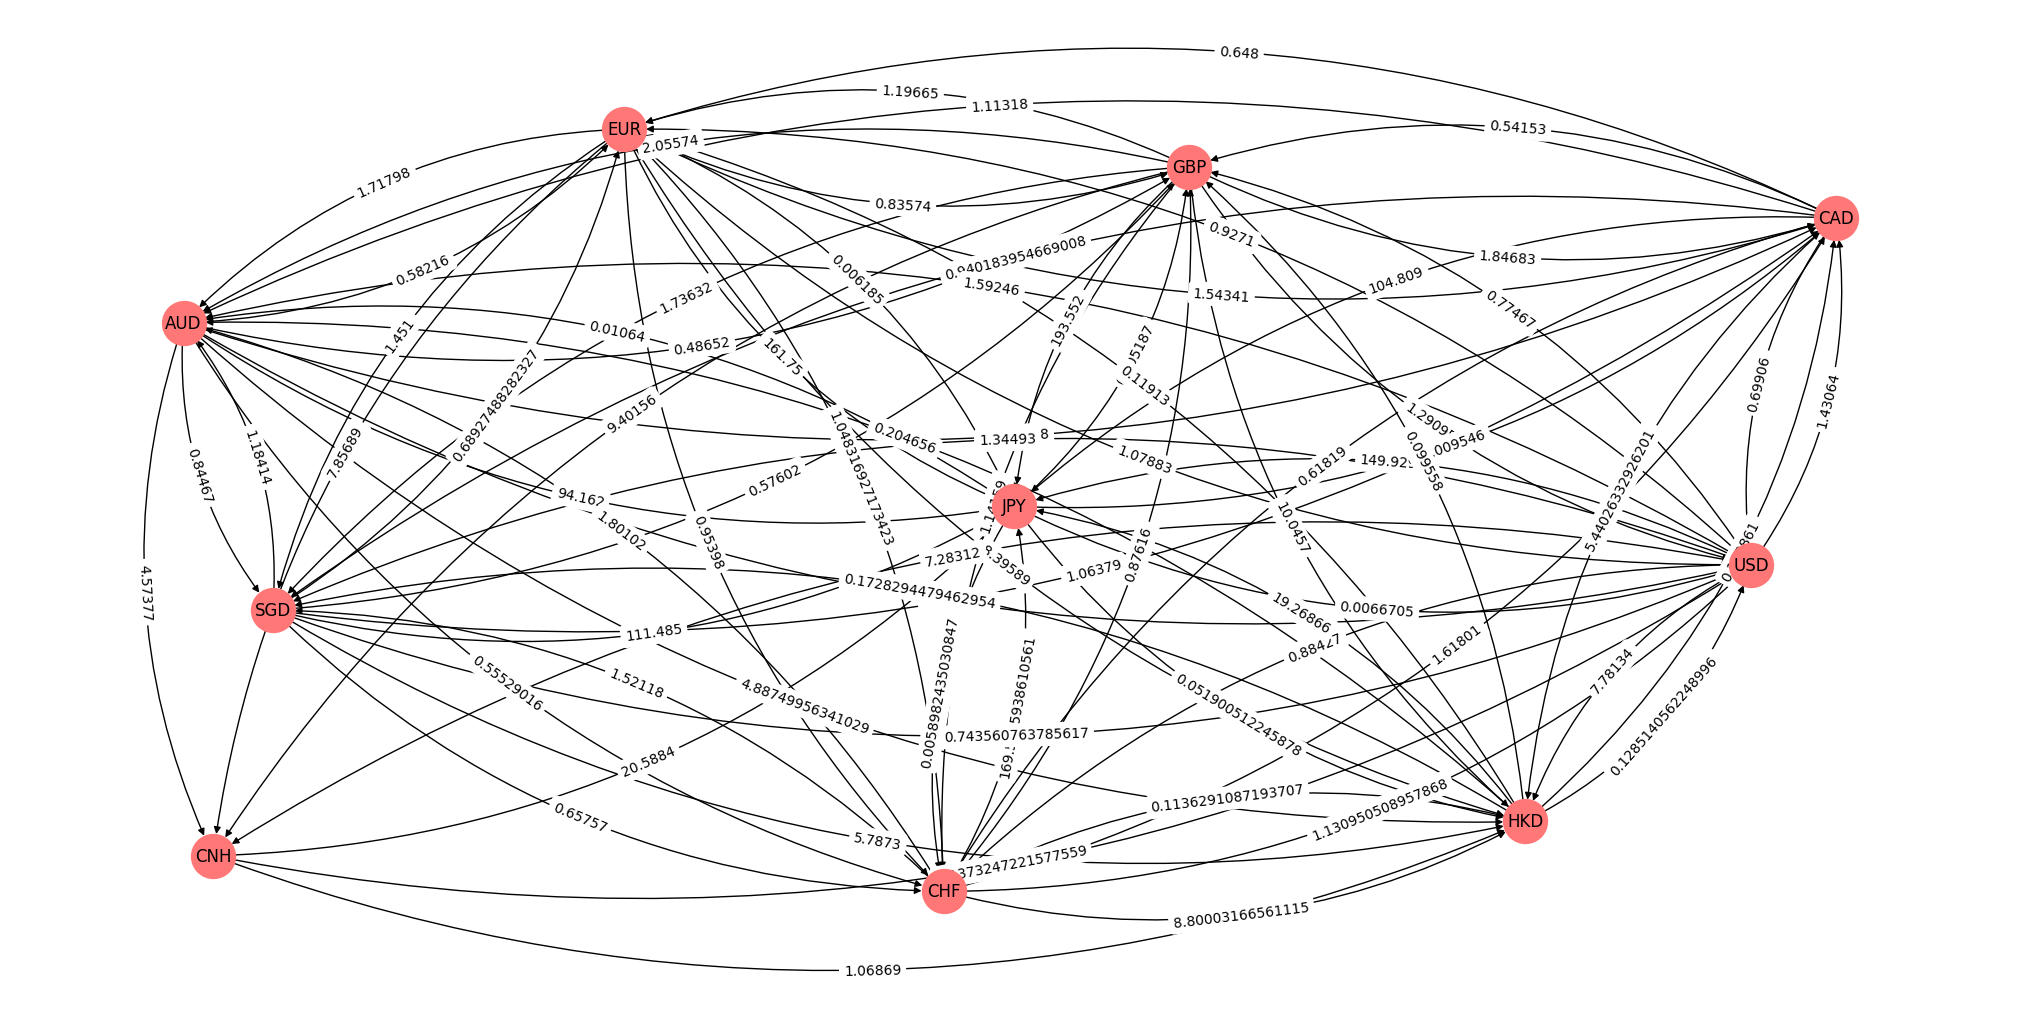

In [22]:
# Visualize the forex graph.

G = nx.DiGraph()

for currency1, rates in graph.items():
    for currency2, rate in rates.items():
        G.add_edge(currency1, currency2, weight=rate)

pos = nx.nx_pydot.graphviz_layout(G, prog="neato")
edge_labels = nx.get_edge_attributes(G, "weight")

plt.figure(figsize=(20, 10))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="#FF7777", connectionstyle="arc3,rad=0.2")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, connectionstyle="arc3,rad=0.2")

plt.savefig("graph.png", dpi=300)
plt.show()

In [ ]:
# Simple functions to help perform arbitrage.

def graph_exchange_to_log(graph: dict[str, dict[str, float]]) -> dict[str, dict[str, float]]:
    log_graph = dict()
    for currency in graph:
        log_graph[currency] = {c: -math.log(w) for c, w in graph[currency].items()}
    return log_graph

def bellman_ford(graph: dict[str, dict[str, float]]) -> bool:
    # Create a new graph in which each weight is the negative logarithm of the exchange rate.
    graph = graph_exchange_to_log(graph)

    # Add a sentinel source node with a weight 0 edge to each node.
    graph["\0"] = {c: 0 for c in graph}

    # Initialize the Bellman-Ford data structures.
    distance = {c: float("inf") for c in graph}
    distance["\0"] = 0
    predecessor = {c: None for c in graph}

    # Relax the edges V - 1 times.
    for _ in range(len(graph) - 1):
        for c1 in graph:
            for c2 in graph[c1]:
                weight = graph[c1][c2]
                if distance[c1] + weight < distance[c2]:
                    distance[c2] = distance[c1] + weight
                    predecessor[c2] = c1

    # Try to relax edges one more time. If possible, then there is a negative cycle.
    skips = 0
    for c1 in graph:
        for c2 in graph[c1]:
            weight = graph[c1][c2]
            if distance[c1] + weight < distance[c2]:
                if skips > 0:
                    skips -= 1
                    continue
                predecessor[c2] = c1
                visited = {c: False for c in graph}
                visited[c2] = True
                while not visited[c1]:
                    visited[c1] = True
                    c1 = predecessor[c1]
                negative_cycle = [c1]
                c2 = predecessor[c1]
                while c1 != c2:
                    negative_cycle = [c2] + negative_cycle
                    c2 = predecessor[c2]
                return negative_cycle

    return False

result = bellman_ford(graph)
if result:
    result.append(result[0])
    cycle = [1]
    # print(" -> ".join(result) + " -> " + result[0])
    for i, symbol in enumerate(result[:-1]):
        cycle.append(symbol)
        cycle.append(cycle[-2] * graph[symbol][result[i+1]])
    cycle.append(result[0])
    cycle = [" ".join([str(cycle[i]), cycle[i+1]]) for i in range(0, len(cycle), 2)]
    print(" -> ".join(cycle))

In [23]:
q = pd.read_csv("/Users/eamontracey/Documents/ND/School/Senior/Spring/HFT/Bellman_Ford_FX/forex/casche_all_arbitrages.csv")
q

,timestamp,cycle,profit
0,1743552001,USD/JPY/CHF/USD,1.000016
1,1743552001,USD/CHF/USD,1.000037
2,1743552005,USD/CAD/HKD/GBP/USD,1.000007
3,1743552005,CAD/HKD/CAD,1.000061
4,1743552005,USD/EUR/HKD/USD,1.000011
...,...,...,...
4516970,1743638398,USD/JPY/CHF/HKD/USD,1.000009
4516971,1743638399,USD/CHF/HKD/USD,1.000083
4516972,1743638399,JPY/CHF/HKD/JPY,1.000046
4516973,1743638399,USD/EUR/CHF/HKD/USD,1.000052


In [25]:
q.sort_values(by="profit")

,timestamp,cycle,profit
4466098,1743629850,USD/HKD/USD,1.000000
4466071,1743629842,USD/HKD/USD,1.000000
4442941,1743626564,USD/HKD/USD,1.000000
3438116,1743610221,USD/HKD/USD,1.000000
4466438,1743630069,USD/HKD/USD,1.000000
...,...,...,...
4402777,1743624809,USD/SGD/HKD/JPY/EUR/USD,1.005752
4403233,1743624809,USD/SGD/CHF/JPY/EUR/USD,1.005755
4402813,1743624809,EUR/SGD/HKD/JPY/EUR,1.005760
4402969,1743624809,EUR/SGD/CHF/JPY/EUR,1.005764


In [31]:
currencies = []
for cycle in q["cycle"].to_list():
    currencies.extend(cycle.split("/"))
from collections import Counter
Counter(currencies).most_common()

[('USD', 5845066),
 ('HKD', 4267776),
 ('CHF', 3267827),
 ('EUR', 2682869),
 ('JPY', 1929241),
 ('CAD', 1782711),
 ('GBP', 1688169),
 ('AUD', 1555498),
 ('SGD', 1224844),
 ('CNH', 186932)]